## locate most activated units

In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from matplotlib import pyplot as plt, rcParams, animation
import glob
import scipy
import pytorch_models
import csv
import matplotlib.patches as mpatches

In [105]:
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/trained_cnns"
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224"
MODEL_DIRECTORY = "../../../project2/bermanm/netdissect/trained_cnns/resnet18_cam"
FEATURES_NAMES = ["layer4"]
DATASET = "pascal"
IMG_SIZE = 224

classes = ['indoor', 'nature', 'urban outdoor']
#features_blobs = []
gridwidth = 4
gridheight = 1
gap = 3

### load model

In [106]:
# define feature hooks
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

In [107]:
def load_model(features_names):
    arch = 'resnet18_cam'
    model_file = os.path.join(MODEL_DIRECTORY, 'checkpoint_021_done.pth.tar')
    model = pytorch_models.__dict__[arch](num_classes=3)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {k[2:]: v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    model.eval()
    return model

In [108]:
# get softmax weight
def get_softmax_weight(model):
    params = list(model.parameters())
    weight_softmax = params[-2].data.numpy()
    weight_softmax[weight_softmax<0] = 0
    return weight_softmax

In [109]:
model = load_model(FEATURES_NAMES)

In [110]:
weight_softmax = get_softmax_weight(model)

### prepare images

In [74]:
# load the test images from the BroDen dataset
def load_image(dataset):
    files = glob.glob(os.path.join(DATA_DIRECTORY, 'images', dataset, '*.jpg'))
    return files

In [75]:
# load the image transformer
def returnTF():
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # why normalize it this way?
    ])
    return tf

In [76]:
files = load_image(DATASET)

### forward pass

In [77]:
def forward_image(files, ind, features_blobs, verbose=True):
    del features_blobs[:]
    tf = returnTF()    # image transformer
    img = Image.open(files[ind])
    if verbose:
        plt.imshow(img)
    
    tf_img = tf(img)
    display_tf_img = np.rollaxis(tf_img.numpy(),0,3)
    
    input_img = V(tf_img.unsqueeze(0))
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs, idx = probs.numpy(), idx.numpy()
    
    if verbose:
        print('--- SCENE CATEGORIES ---')
        for i in range(0, 3):
            print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    
    return features_blobs, idx, probs, img, tf_img

### build heatmap

In [111]:
def heatmap(features_blobs, probs, idx, verbose=True):
    if len(features_blobs) == 1:
        feature_conv = features_blobs[0]
    else:
        print("features blobs is not emptied")
        return
    
    class_map = dict([(i, classes[i]) for i in range(len(classes))])
    if verbose:
        print(class_map)
    nc, h, w = feature_conv.shape # nc=512, h=14, w=14
    cams = []

    for i in range(3):
        class_idx = [idx[i]]
        cls = class_map[class_idx[0]]
        if verbose:
            print("class {}: {} {}".format(i+1, cls, probs[i]))
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cams.append(cam)
        
    norm = plt.Normalize(vmin=np.min(cams), vmax=np.max(cams))
    cams = np.concatenate([norm(cam).reshape(h, w) for cam in cams])
    resize_cams = scipy.misc.imresize(cams, (IMG_SIZE * 3, IMG_SIZE, 3))
    
    for i in range(3):
        rc = resize_cams[i*IMG_SIZE:(i+1)*IMG_SIZE, :]
        class_idx = [idx[i]]
        cls = class_map[class_idx[0]]
        prob = probs[i]
        plt.imsave(os.path.join(OUTPUT_FOLDER, 'temp', str(image_id) + "_" + cls + "_" +str(prob) + '.jpg'), 
                   rc, vmin=0, vmax=255, cmap="afmhot")

### visualize

In [79]:
def visualize(files, ind, verbose=True):
    img = Image.open(files[ind])
    heatmaps = glob.glob(os.path.join(OUTPUT_FOLDER, 'temp', str(image_id) + '*.jpg'))
    tiled = np.full(((IMG_SIZE + gap) * gridheight - gap, (IMG_SIZE + gap) * gridwidth - gap, 3), 255, dtype='uint8')
    
    labels = []
    for x in range(4):
        row = x // gridwidth
        col = x % gridwidth
        if x == 0:
            curr_img = img
            labels.append("original")
        else:
            heatmap = heatmaps[x-1]
            info = heatmap.split("/")[-1].split(".")
            cls = info[0].split("_")[1]
            prob = round(float('0.' + info[1]), 3)
            labels += [cls + ":" + str(prob)]
            if verbose:
                print("class: {}, probability: {}".format(cls, prob))
            
            img_heat = Image.open(heatmap)
            plt.imshow(img_heat)
            curr_img = Image.blend(img, img_heat, 0.6)
        tiled[row * (IMG_SIZE + gap) : row * (IMG_SIZE + gap) + IMG_SIZE, 
                col * (IMG_SIZE + gap) : col * (IMG_SIZE + gap) + IMG_SIZE,:] = curr_img 
  
    locs, _ = plt.xticks()
    plt.xticks(np.array([IMG_SIZE // 2, IMG_SIZE + IMG_SIZE // 2,  IMG_SIZE * 2 + IMG_SIZE // 3 * 2,
                         IMG_SIZE * 3 + IMG_SIZE // 1.2]), tuple(labels))
    if verbose:
        plt.imshow(tiled)
    labels = "_".join(labels[1:])
    plt.imsave(os.path.join(OUTPUT_FOLDER, "classes", str(ind) +"_" + labels + ".jpg"), tiled)

In [80]:
def retrieve_image(ind):
    file = glob.glob(os.path.join(OUTPUT_FOLDER, "classes", str(ind) + "*.jpg"))[0]
    info = file.split("/")[-1][:-4]
    info = info.split("_")
    labels = ["original"] + info[1:]
    plt.xticks(np.array([IMG_SIZE // 2, IMG_SIZE + IMG_SIZE // 2,  IMG_SIZE * 2 + IMG_SIZE // 3 * 2,
                         IMG_SIZE * 3 + IMG_SIZE // 1.2]), tuple(labels))
    img = Image.open(file)
    plt.imshow(img)

### retrieve object information

In [81]:
def load_labels():
    labels = {}
    label_path = os.path.join(DATA_DIRECTORY, "label.csv")
    with open(label_path) as labels_file:
        reader = csv.reader(labels_file)
        for i, line in enumerate(reader):
            if i != 0:
                labels[int(line[0])] = line[1]
    return labels

In [82]:
labels = load_labels()

In [83]:
def reconstruct_object(obj_labels, files, ind, verbose=True):
    f = files[ind]
    iid = f.split("/")[-1].split(".")[0]
    path = "/".join(f.split("/")[:-1])
    obj_f = os.path.join(path, iid + "_object.png")
    obj_img = Image.open(obj_f)
    pixels = list(obj_img.getdata())
    objects = {}
    for p in pixels:
        lb = p[0]
        if lb != 0:
            if lb not in objects:
                objects[lb]= {"name": obj_labels[lb], "count": 1}
            else:
                objects[lb]["count"] += 1
    if verbose:
        print("objects: ", objects)
    return obj_img, objects

### represent top_n objects

In [84]:
palette = [(153 / 255, 0 , 0), 
           (0, 0, 153 / 255), 
           (0, 153 / 255, 0), 
           (1, 1, 0), 
           (153 / 255, 0, 153 / 255), 
           (0, 153 / 255, 153 / 255)]

In [85]:
def represent_objects(objects, palette, obj_img, img_size, ind, top_n=6, verbose=True):
    keys = list(objects.keys())
    ls_objects = [(k, objects[k]["name"], objects[k]["count"]) for k in keys]
    sorted_objects = sorted(ls_objects, key=lambda obj:obj[2], reverse=True)[:top_n]
    top_objects = [ob[0] for ob in sorted_objects]
    top_names = [ob[1] for ob in sorted_objects]
    obj_pixel = obj_img.load()
    rep_pixel = [[(1.0, 1.0, 1.0) if obj_pixel[i, j][0] not in top_objects
                 else palette[top_objects.index(obj_pixel[i, j][0])] for i in range(obj_img.size[0])]
                for j in range(obj_img.size[1])]
    rep_pixel = scipy.misc.imresize(rep_pixel, (img_size, img_size))
    if verbose:
        print("top {} objects: {}".format(top_n, sorted_objects))
    patches =[mpatches.Patch(color=palette[i],label=top_names[i]) for i in range(len(top_names))]
    plt.legend(handles=patches, loc=7, borderaxespad=-10)
    plt.imshow(rep_pixel)
    plt.imsave(os.path.join(OUTPUT_FOLDER, "object", str(ind)+".jpg"), rep_pixel)
    return patches, top_objects

### combine with a class activation map

In [86]:
def combine_object_cam(ind, cls, patches):
    obj_img = Image.open(os.path.join(OUTPUT_FOLDER, "object", str(ind) + ".jpg"))
    cls_img = Image.open(glob.glob(os.path.join(OUTPUT_FOLDER, "temp", str(ind) + "_"+ cls + "*.jpg"))[0])
    combined_img = Image.blend(obj_img, cls_img, 0.6)
    plt.legend(handles=patches, loc=7, borderaxespad=-10)
    plt.imshow(combined_img)

### probe single image

In [420]:
image_id = 299

--- SCENE CATEGORIES ---
0.522 -> urban outdoor
0.425 -> nature
0.052 -> indoor


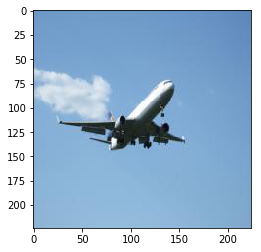

In [421]:
features_blobs, idx, probs, img, tf_img = forward_image(files, image_id, features_blobs)

In [422]:
heatmap(features_blobs, probs, idx)

{0: 'indoor', 1: 'nature', 2: 'urban outdoor'}
class 1: urban outdoor 0.5224190950393677
class 2: nature 0.4253001809120178
class 3: indoor 0.05228076130151749


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


class: indoor, probability: 0.052
class: urban outdoor, probability: 0.522
class: nature, probability: 0.425


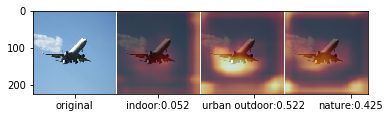

In [423]:
visualize(files, image_id)

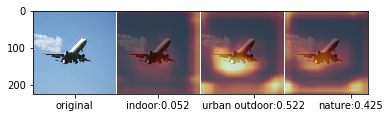

In [424]:
retrieve_image(image_id)

In [425]:
obj_img, objects = reconstruct_object(labels, files, image_id)

objects:  {13: {'name': 'sky', 'count': 11716}, 154: {'name': 'airplane', 'count': 828}}


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


top 6 objects: [(13, 'sky', 11716), (154, 'airplane', 828)]


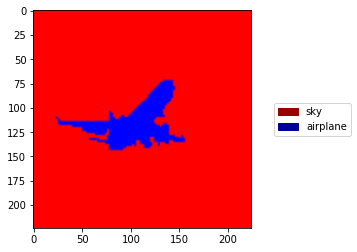

In [426]:
patches, top_objects = represent_objects(objects, palette, obj_img, IMG_SIZE, image_id)

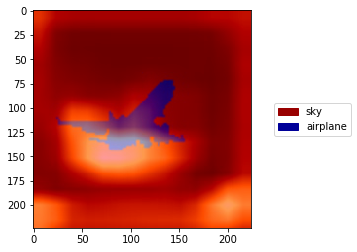

In [430]:
combine_object_cam(image_id, "urban outdoor", patches)

### detect indicative objects

In [287]:
def quantify(files, model, fbs, labels=labels, threshold=0.2, ids=None, verbose=True):
    act_objects = {"indoor": {}, "nature": {}, "urban outdoor": {}}
    if ids == None:
        ids = list(range(len(files)))
    for id in ids:
        if id % 200 == 0:
            print("probing: {}".format(id))
            features_blobs, idx, probs, img, tf_img = forward_image(files, id, fbs)
        else:
            features_blobs, idx, probs, img, tf_img = forward_image(files, id, fbs, verbose=False)
        cls = classes[idx[0]]
        
        if len(fbs) == 1:
            feature_conv = fbs[0]
        else:
            print("features blobs is not emptied")
            return
        
        if verbose:
            print("class: ", cls)
    
        nc, h, w = feature_conv.shape
        
        obj_img, objs = reconstruct_object(labels, files, id, verbose=False)
        if verbose:
            print("objects: ", objs)
            
        cam = weight_softmax[idx[0]].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        norm = plt.Normalize(vmin=np.min(cam), vmax=np.max(cam))
        resize_cam = scipy.misc.imresize(norm(cam), (obj_img.size[0], obj_img.size[1], 3))
        max_resize = np.max(resize_cam)
        resize_cam[resize_cam < threshold * max_resize] = 0
        if verbose:
            plt.imshow(resize_cam)
        
        obj_pixel = np.array([t[0] for t in obj_img.getdata()]).reshape(obj_img.size[0], obj_img.size[1])
        obj_pixel[resize_cam == 0] = 0
        activated_obj = np.unique(obj_pixel)
        for obj in activated_obj:
            if obj != 0:
                act_objects[cls][labels[obj]] = act_objects[cls].get(labels[obj], 0) + 1
        act_objects[cls]["count"] = act_objects[cls].get("count", 0) + 1
    return act_objects
                

probing: 0
--- SCENE CATEGORIES ---
0.705 -> nature
0.156 -> urban outdoor
0.139 -> indoor


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


probing: 200
--- SCENE CATEGORIES ---
0.800 -> indoor
0.129 -> urban outdoor
0.071 -> nature
probing: 400
--- SCENE CATEGORIES ---
0.814 -> indoor
0.115 -> nature
0.072 -> urban outdoor
probing: 600
--- SCENE CATEGORIES ---
0.847 -> indoor
0.088 -> urban outdoor
0.065 -> nature
probing: 800
--- SCENE CATEGORIES ---
0.438 -> nature
0.335 -> indoor
0.227 -> urban outdoor
probing: 1000
--- SCENE CATEGORIES ---
0.749 -> indoor
0.205 -> urban outdoor
0.045 -> nature
probing: 1200
--- SCENE CATEGORIES ---
0.610 -> nature
0.289 -> urban outdoor
0.102 -> indoor
probing: 1400
--- SCENE CATEGORIES ---
0.379 -> indoor
0.374 -> nature
0.248 -> urban outdoor
probing: 1600
--- SCENE CATEGORIES ---
0.456 -> indoor
0.338 -> nature
0.206 -> urban outdoor
probing: 1800
--- SCENE CATEGORIES ---
0.537 -> urban outdoor
0.313 -> indoor
0.150 -> nature
probing: 2000
--- SCENE CATEGORIES ---
0.390 -> indoor
0.311 -> nature
0.299 -> urban outdoor
probing: 2200
--- SCENE CATEGORIES ---
0.681 -> indoor
0.163 -> 

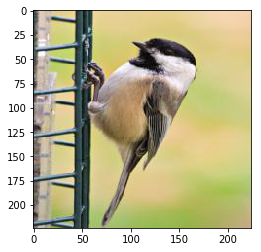

In [288]:
act_objects = quantify(files, model, fbs=features_blobs, threshold=0.5, verbose=False)

In [289]:
print(act_objects)

{'indoor': {'wall': 2379, 'person': 1574, 'pillow': 32, 'count': 5166, 'windowpane': 540, 'ground': 792, 'bus': 288, 'table': 1066, 'car': 363, 'ceiling': 489, 'cabinet': 399, 'cat': 590, 'bag': 97, 'counter': 24, 'skyscraper-s': 41, 'building': 816, 'paper': 173, 'rope': 118, 'tvmonitor': 368, 'computer': 72, 'floor': 1272, 'painting': 397, 'signboard': 131, 'motorbike': 128, 'plant': 33, 'sky': 392, 'tree': 469, 'mountain': 53, 'fence': 197, 'water': 68, 'fabric': 404, 'curtain': 278, 'chair': 830, 'dog': 505, 'pole': 313, 'railing': 10, 'boat': 33, 'sofa': 624, 'pot': 133, 'plaything': 152, 'shelves': 307, 'pack': 63, 'door': 322, 'grass': 413, 'light': 306, 'step': 18, 'bottle': 306, 'cup': 175, 'pottedplant': 262, 'carpet': 115, 'train': 113, 'wheel': 11, 'mouse': 57, 'leg': 50, 'track': 60, 'road': 301, 'ear': 11, 'metal': 59, 'food': 154, 'wood': 137, 'bedclothes': 188, 'bicycle': 143, 'bed': 93, 'armchair': 8, 'keyboard': 73, 'box': 192, 'sidewalk': 97, 'cushion': 41, 'truck': 

In [290]:
obj_path = os.path.join(OUTPUT_FOLDER, "object_0.5.npz")

In [292]:
np.savez(obj_path, **act_objects)

In [311]:
act_objects['nature']

{'tree': 1157,
 'count': 2901,
 'water': 533,
 'sky': 1010,
 'car': 126,
 'ground': 805,
 'bird': 268,
 'building': 414,
 'grass': 1119,
 'sheep': 138,
 'person': 694,
 'pole': 137,
 'horse': 125,
 'saddle': 6,
 'floor': 118,
 'fabric': 61,
 'dog': 234,
 'wall': 134,
 'chair': 74,
 'motorbike': 110,
 'cow': 105,
 'boat': 208,
 'sofa': 55,
 'bedclothes': 51,
 'bicycle': 135,
 'rock': 172,
 'wood': 98,
 'truck': 9,
 'cat': 166,
 'road': 149,
 'mountain': 300,
 'fence': 177,
 'train': 140,
 'track': 105,
 'snow': 90,
 'pot': 8,
 'eyebrow': 39,
 'table': 49,
 'bench': 17,
 'airplane': 124,
 'flag': 4,
 'flower': 27,
 'bottle': 34,
 'vase': 1,
 'bush': 10,
 'box': 20,
 'sand': 57,
 'plaything': 19,
 'rope': 65,
 'painting': 5,
 'railing': 6,
 'sculpture': 4,
 'sidewalk': 28,
 'light': 11,
 'signboard': 28,
 'bag': 18,
 'chest of drawers': 2,
 'pack': 30,
 'bucket': 14,
 'carpet': 20,
 'windowpane': 18,
 'curtain': 15,
 'wheel': 4,
 'house': 10,
 'can': 1,
 'plate': 7,
 'seat cushion': 1,
 '

In [312]:
act_objects['indoor']

{'wall': 2379,
 'person': 1574,
 'pillow': 32,
 'count': 5166,
 'windowpane': 540,
 'ground': 792,
 'bus': 288,
 'table': 1066,
 'car': 363,
 'ceiling': 489,
 'cabinet': 399,
 'cat': 590,
 'bag': 97,
 'counter': 24,
 'skyscraper-s': 41,
 'building': 816,
 'paper': 173,
 'rope': 118,
 'tvmonitor': 368,
 'computer': 72,
 'floor': 1272,
 'painting': 397,
 'signboard': 131,
 'motorbike': 128,
 'plant': 33,
 'sky': 392,
 'tree': 469,
 'mountain': 53,
 'fence': 197,
 'water': 68,
 'fabric': 404,
 'curtain': 278,
 'chair': 830,
 'dog': 505,
 'pole': 313,
 'railing': 10,
 'boat': 33,
 'sofa': 624,
 'pot': 133,
 'plaything': 152,
 'shelves': 307,
 'pack': 63,
 'door': 322,
 'grass': 413,
 'light': 306,
 'step': 18,
 'bottle': 306,
 'cup': 175,
 'pottedplant': 262,
 'carpet': 115,
 'train': 113,
 'wheel': 11,
 'mouse': 57,
 'leg': 50,
 'track': 60,
 'road': 301,
 'ear': 11,
 'metal': 59,
 'food': 154,
 'wood': 137,
 'bedclothes': 188,
 'bicycle': 143,
 'bed': 93,
 'armchair': 8,
 'keyboard': 73,

In [313]:
act_objects['urban outdoor']

{'sky': 1020,
 'tree': 908,
 'building': 1192,
 'ground': 936,
 'bicycle': 106,
 'count': 2036,
 'person': 596,
 'signboard': 128,
 'pole': 369,
 'fence': 335,
 'water': 189,
 'boat': 145,
 'road': 471,
 'grass': 784,
 'car': 405,
 'light': 77,
 'mountain': 161,
 'airplane': 341,
 'truck': 50,
 'bench': 22,
 'rope': 57,
 'motorbike': 129,
 'laminate': 3,
 'sheep': 19,
 'train': 136,
 'chair': 73,
 'horse': 179,
 'leg': 48,
 'track': 109,
 'pottedplant': 59,
 'blind': 4,
 'sidewalk': 129,
 'eyebrow': 31,
 'railing': 8,
 'step': 5,
 'saddle': 46,
 'poster': 30,
 'sofa': 18,
 'rock': 50,
 'bird': 35,
 'sculpture': 9,
 'sand': 20,
 'wall': 55,
 'snow': 34,
 'metal': 25,
 'bucket': 30,
 'pack': 19,
 'bus': 47,
 'table': 36,
 'paper': 2,
 'flag': 20,
 'cow': 31,
 'wood': 40,
 'fabric': 39,
 'dog': 69,
 'ceiling': 12,
 'loudspeaker': 4,
 'cabinet': 12,
 'pot': 25,
 'box': 13,
 'floor': 30,
 'bridge': 10,
 'ashcan': 14,
 'brown-c': 2,
 'bedclothes': 11,
 'flower': 16,
 'plaything': 7,
 'bottle